In [1]:
!nvidia-smi

Fri Nov 26 22:11:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 496.76       Driver Version: 496.76       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   65C    P8    13W /  N/A |    890MiB /  6144MiB |     37%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
import cv2
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import sklearn
import math
from tensorflow.keras.models import Model
import tensorflow_addons as tfa
import seaborn as sns

In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
BATCH_SIZE = 64

In [5]:
ds = tfds.load('deep_weeds', as_supervised= True, shuffle_files= False, batch_size = -1)

Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


In [6]:
images, labels = ds['train']

In [7]:
del ds
#del images
#del labels

# Load Model here

In [8]:
model  = tf.keras.models.load_model('CNN_Models/3_block_cnn/3_blockV2.h5')
model.compile()

In [9]:
model.summary()

Model: "2_block_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Original_Image (InputLayer)  [(None, 256, 256, 5)]     0         
_________________________________________________________________
random_flip_29 (RandomFlip)  (None, 256, 256, 5)       0         
_________________________________________________________________
random_rotation_29 (RandomRo (None, 256, 256, 5)       0         
_________________________________________________________________
rescaling_29 (Rescaling)     (None, 256, 256, 5)       0         
_________________________________________________________________
conv2d_114 (Conv2D)          (None, 128, 128, 64)      2944      
_________________________________________________________________
conv2d_115 (Conv2D)          (None, 64, 64, 64)        36928     
_________________________________________________________________
batch_normalization_56 (Batc (None, 64, 64, 64)        

## GradCAM Class

In [10]:
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()
            
    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")
        
    def compute_heatmap(self, image, eps=1e-8):
            # construct our gradient model by supplying (1) the inputs
            # to our pre-trained model, (2) the output of the (presumably)
            # final 4D layer in the network, and (3) the output of the
            # softmax activations from the model
            gradModel = Model(
                inputs=[self.model.inputs],
                outputs=[self.model.get_layer(self.layerName).output,
                    self.model.output])
        
        # record operations for automatic differentiation
            with tf.GradientTape() as tape:
                # cast the image tensor to a float-32 data type, pass the
                # image through the gradient model, and grab the loss
                # associated with the specific class index
                inputs = tf.cast(image, tf.float32)
                (convOutputs, predictions) = gradModel(inputs)
                loss = predictions[:, self.classIdx]
            # use automatic differentiation to compute the gradients
            grads = tape.gradient(loss, convOutputs)
            
            
            # compute the guided gradients
            castConvOutputs = tf.cast(convOutputs > 0, "float32")
            castGrads = tf.cast(grads > 0, "float32")
            guidedGrads = castConvOutputs * castGrads * grads
            # the convolution and guided gradients have a batch dimension
            # (which we don't need) so let's grab the volume itself and
            # discard the batch
            convOutputs = convOutputs[0]
            guidedGrads = guidedGrads[0]
            
            # compute the average of the gradient values, and using them
            # as weights, compute the ponderation of the filters with
            # respect to the weights
            weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
            cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
            
            # grab the spatial dimensions of the input image and resize
            # the output class activation map to match the input image
            # dimensions
            (w, h) = (image.shape[2], image.shape[1])
            heatmap = cv2.resize(cam.numpy(), (w, h))
            # normalize the heatmap such that all values lie in the range
            # [0, 1], scale the resulting values to the range [0, 255],
            # and then convert to an unsigned 8-bit integer
            numer = heatmap - np.min(heatmap)
            denom = (heatmap.max() - heatmap.min()) + eps
            heatmap = numer / denom
            heatmap = (heatmap * 255).astype("uint8")
            # return the resulting heatmap to the calling function
            return heatmap
        
    def overlay_heatmap(self, heatmap, image, alpha=0.5,
        colormap=cv2.COLORMAP_JET):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

In [11]:
def preprocess(img):
    org = img
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=3)
    sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=3)
    sobel = np.sqrt(sobelx**2 + sobely**2)
    im_max = np.max(sobel)
    im_min = np.min(sobel)
    sobel = (sobel - im_min)/(im_max - im_min)
    sobel = sobel * 255
    sobel = cv2.GaussianBlur(sobel,(3,3),cv2.BORDER_DEFAULT)
    gray = np.expand_dims(gray, axis = 2)
    sobel = np.expand_dims(sobel, axis = 2)
    return np.concatenate([org,gray,sobel], axis = 2)

In [33]:
test = cv2.imread("Test_5.jpg")

[[1.0368788e-08 6.6796201e-01 1.8584602e-10 5.6515267e-07 5.0329832e-06
  7.6811437e-09 3.4211718e-07 3.3202744e-01 4.5913716e-06]]


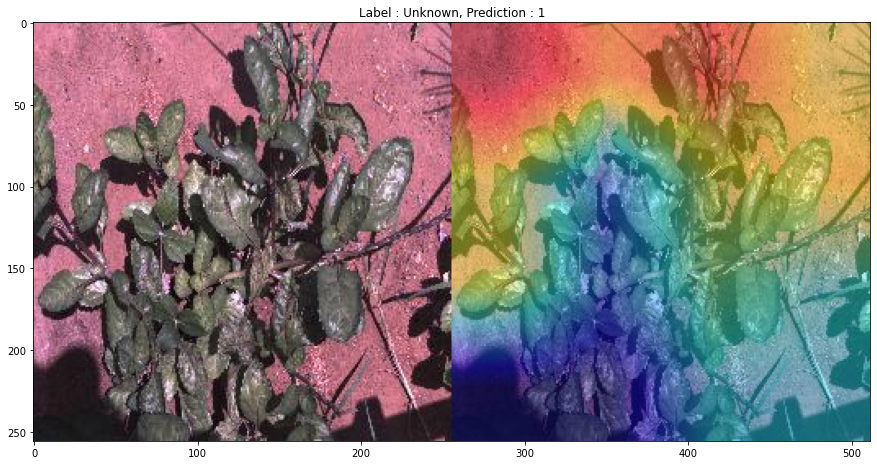

In [35]:
True_Matches_Only = False

for i in range(1):
    if True_Matches_Only:
        y = i
        while y == i :
            rel_ind = tf.where(labels == i)
            ind = rel_ind[np.random.randint(0, len(rel_ind))][0]
            image = images[ind].numpy()
            #image = t
            pre = preprocess(image)
            im = np.expand_dims(pre, axis = 0)

            pred = model.predict(im)
            y = np.argmax(pred)
    else:
        #rel_ind = tf.where(labels == 0)
        #ind = rel_ind[np.random.randint(0, len(rel_ind))][0]
        #ind = 2
        #image = images[ind].numpy()
        image = test
        pre = preprocess(image)
        im = np.expand_dims(pre, axis = 0)

        pred = model.predict(im)
        print(pred)
        y = np.argmax(pred)

    cam = GradCAM(model, y)
    heatmap = cam.compute_heatmap(im)

    (heatmap, output) = cam.overlay_heatmap(heatmap, image, alpha = 0.6)

    output = np.hstack([image, output])
    
    fig = plt.figure(figsize = (15,15))
    ax = fig.add_subplot(1,1,1)
    plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB), cmap = 'jet')
    #ax.set_title(f"Label : {labels[ind]}, Prediction : {y}")
    ax.set_title(f"Label : Unknown, Prediction : {y}")

# HeatMaps

In [15]:
test = tfds.as_numpy(test_ds)
y_label = []

for i in test:
    flat_label = i[1]
    app = np.argmax(flat_label, axis = 1)
    y_label.extend(app)

y_label = np.array(y_label)

In [52]:
y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis = 1)

In [53]:
confusion_matrix = np.zeros((9, 9))

for i in range(len(y_pred)):
    predicted = y_pred[i]
    actual = y_label[i]
    confusion_matrix[actual][predicted] += 1

_, counts = np.unique(y_label, return_counts = True)
for row in range(9):
    for col in range(9):
        confusion_matrix[row][col] /= counts[row]
        confusion_matrix[row][col] *= 100

Text(0.5, 33.0, 'Predicted')

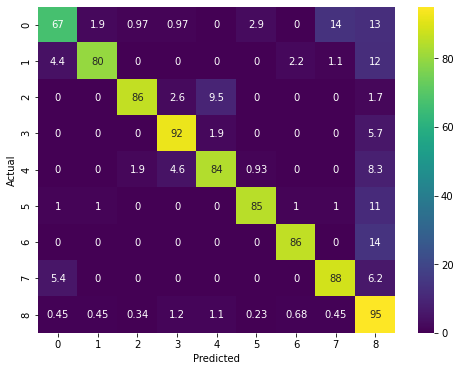

In [54]:
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(1,1,1)
sns.heatmap(confusion_matrix, annot = True, cmap='viridis', ax = ax)
ax.set_ylabel("Actual")
ax.set_xlabel("Predicted")

In [55]:
from sklearn.metrics import classification_report

print(classification_report(y_label, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.67      0.73       103
           1       0.91      0.80      0.85        90
           2       0.94      0.86      0.90       116
           3       0.83      0.92      0.87       105
           4       0.80      0.84      0.82       108
           5       0.93      0.85      0.89        98
           6       0.92      0.86      0.89       114
           7       0.85      0.88      0.87       129
           8       0.92      0.95      0.93       888

    accuracy                           0.90      1751
   macro avg       0.88      0.85      0.86      1751
weighted avg       0.90      0.90      0.89      1751



In [10]:
BATCH_SIZE = 96
AUTOTUNE = tf.data.AUTOTUNE

train_ds, validation_ds, test_ds = tfds.load('deep_weeds', as_supervised= True, shuffle_files= True, split=["train[:70%]", "train[70%:90%]", "train[90%:100%]"], batch_size = BATCH_SIZE)

print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print("Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds))
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))

#Pre-Processing
def one_hot(img, label):
    return (img, tf.one_hot(label,9))

def add_grey_grad(img ,label):
    org_img = img
    img = tf.cast(img, float)
    #img = tf.expand_dims(img, axis = 0)
    gray = tf.image.rgb_to_grayscale(img)
    dy , dx = tf.image.image_gradients(gray)
    dmag = tf.math.sqrt(tf.add(tf.math.square(dy),tf.math.square(dx)))

    #Normalize to 0 - 255
    im_max = tf.math.reduce_max(dmag)
    im_min = tf.math.reduce_min(dmag)
    out = (tf.math.subtract(dmag, im_min) / (im_max - im_min)) * 255
    out = tf.expand_dims(tf.cast(out, tf.uint8), axis = 0)
    out = tfa.image.gaussian_filter2d(out[0])
    
    gray = tf.expand_dims(tf.cast(gray, tf.uint8), axis = 0)
    org_img = tf.concat([org_img,gray[0],out],-1)
    return (org_img, label)

train_ds = train_ds.map(one_hot)
validation_ds = validation_ds.map(one_hot)
test_ds = test_ds.map(one_hot)

train_ds = train_ds.map(add_grey_grad)
validation_ds = validation_ds.map(add_grey_grad)
test_ds = test_ds.map(add_grey_grad)


train_ds = train_ds.shuffle(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE).cache()
validation_ds = validation_ds.shuffle(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE).cache()
test_ds = test_ds.shuffle(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE).cache()

Number of training samples: 128
Number of validation samples: 37
Number of test samples: 19
